## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,95.9,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,84.0,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,95.2,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,97.6,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,98.4,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2


In [2]:
df.shape

(10871, 34)

## Preoaring the (x,y) pairs

### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [4]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [5]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [6]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 34), (10847,))

### Splitting the data

In [7]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 34), (8696,), (1087, 24, 34), (1087,), (1064, 24, 34), (1064,))

### Plotting the splits

In [8]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

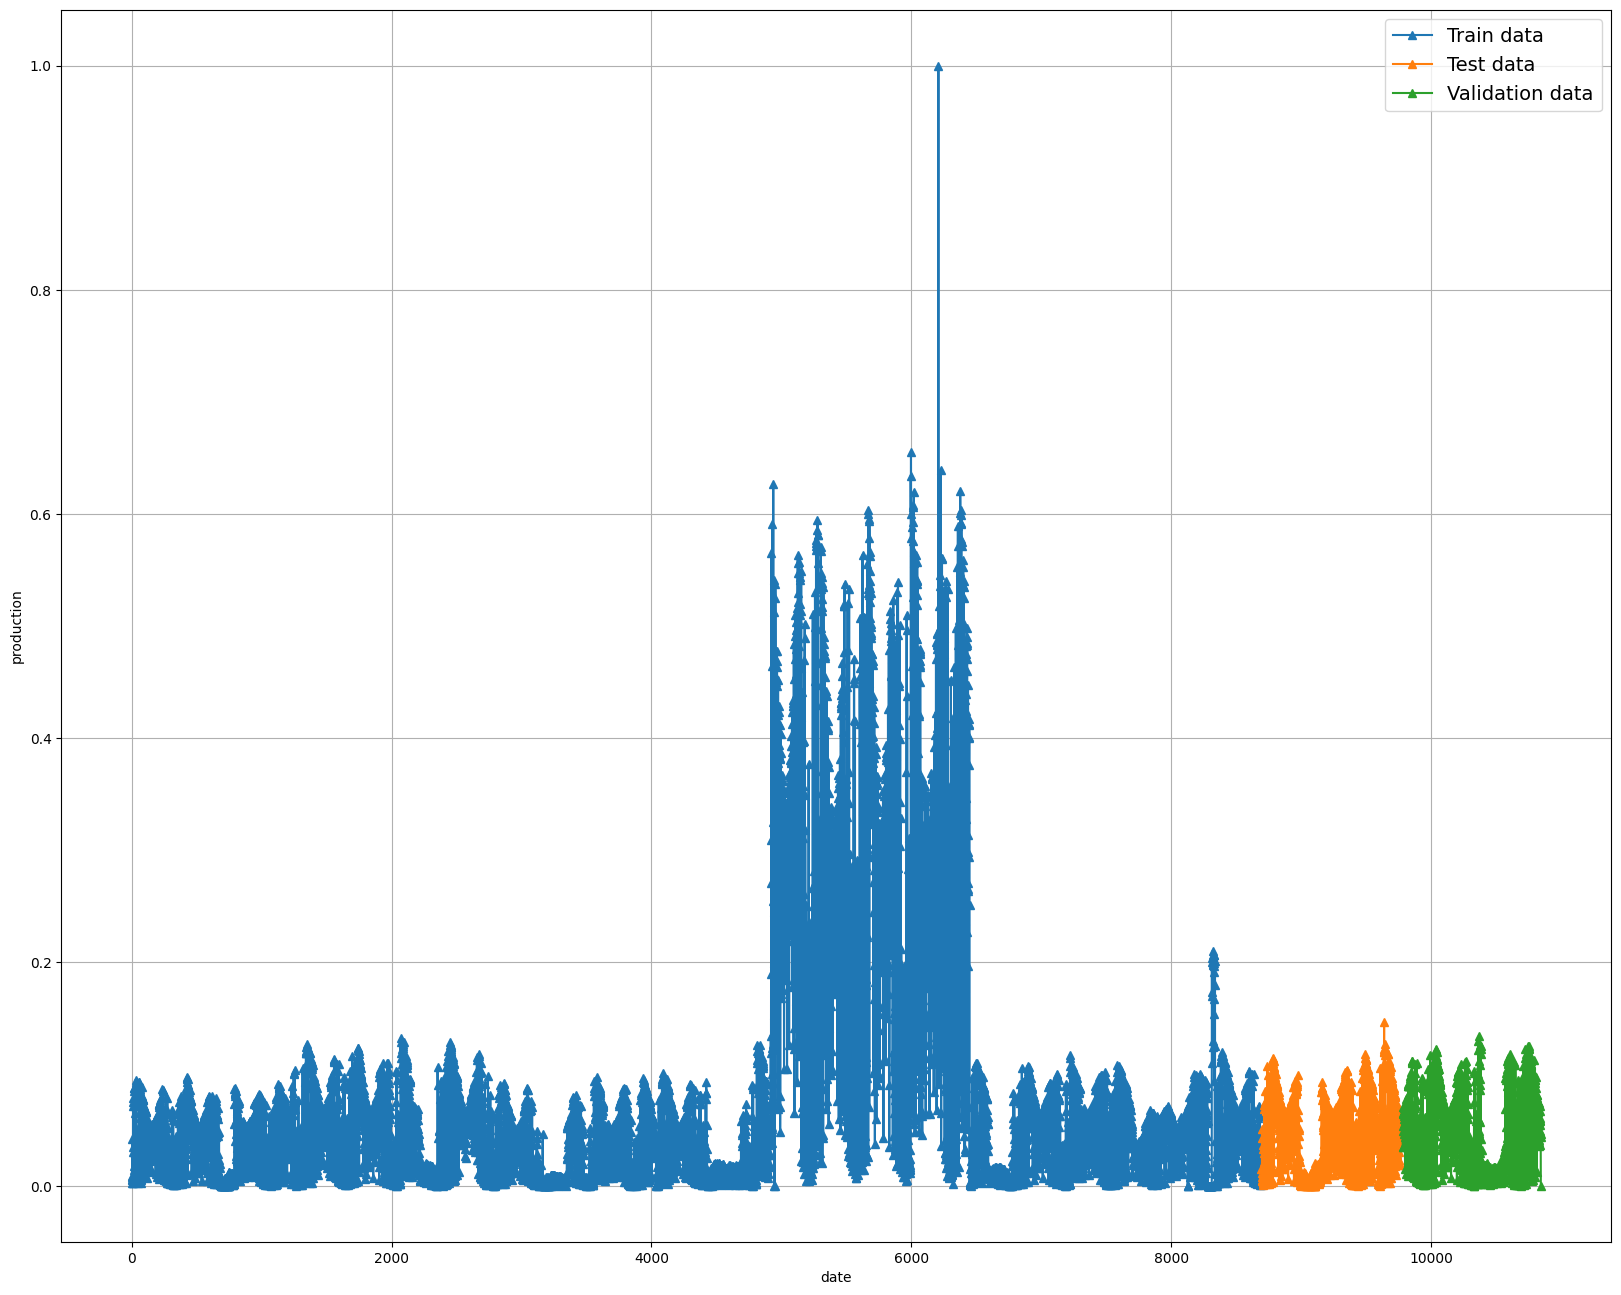

In [9]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [11]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [12]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [13]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [15]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [16]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [17]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 34) -> (8696, 24, 1, 34)


In [18]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=96, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=32, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0016163507080940505))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 96)           │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 64)               │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,633 (365.75 KB)

 Trainable params: 93,633 (365.75 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [19]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 02:40:45] [setup] RAM Tracking...
[codecarbon INFO @ 02:40:45] [setup] CPU Tracking...
[codecarbon WARNING @ 02:40:45] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 02:40:47] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 02:40:47] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 02:40:47] [setup] GPU Tracking...
[codecarbon INFO @ 02:40:48] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:40:48] >>> Tracker's metadata:
[codecarbon INFO @ 02:40:48]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 02:40:48]   Python version: 3.12.3
[codecarbon INFO @ 02:40:48]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 02:40:48]   Available RAM : 15.288 GB
[codecarbon INFO @ 02:40:48]   CPU count: 16
[codecarbon INFO @ 02:

In [20]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [21]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 0.1593 - val_loss: 0.0276
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0443 - val_loss: 0.0281
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0403 - val_loss: 0.0265
Epoch 4/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0381 

[codecarbon INFO @ 02:40:59] Energy consumed for RAM : 0.000017 kWh. RAM Power : 5.732982158660889 W


 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0384

[codecarbon INFO @ 02:40:59] Energy consumed for all CPUs : 0.000125 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0392

[codecarbon INFO @ 02:41:00] Energy consumed for all GPUs : 0.000009 kWh. Total GPU Power : 2.9423753210342163 W
[codecarbon INFO @ 02:41:00] 0.000151 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0393 - val_loss: 0.0269
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0387 - val_loss: 0.0263
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0383 - val_loss: 0.0261
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0377 - val_loss: 0.0263
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0377 - val_loss: 0.0258
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0371 - val_loss: 0.0255
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0371 - val_loss: 0.0282
Epoch 11/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0375

[codecarbon INFO @ 02:41:09] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W


 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0379

[codecarbon INFO @ 02:41:09] Energy consumed for all CPUs : 0.000238 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0385

[codecarbon INFO @ 02:41:10] Energy consumed for all GPUs : 0.000020 kWh. Total GPU Power : 4.147604076136456 W
[codecarbon INFO @ 02:41:10] 0.000289 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0383 - val_loss: 0.0251
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0366 - val_loss: 0.0257
Epoch 13/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0362 - val_loss: 0.0269
Epoch 14/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0372 - val_loss: 0.0240
Epoch 15/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0353 - val_loss: 0.0252
Epoch 16/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0366 - val_loss: 0.0254
Epoch 17/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0358 - val_loss: 0.0250
Epoch 18/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0356

[codecarbon INFO @ 02:41:19] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:41:19] Energy consumed for all CPUs : 0.000350 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0361

[codecarbon INFO @ 02:41:20] Energy consumed for all GPUs : 0.000029 kWh. Total GPU Power : 3.632275189229106 W
[codecarbon INFO @ 02:41:20] 0.000427 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0360 - val_loss: 0.0238
Epoch 19/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0351 - val_loss: 0.0229
Epoch 20/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0340 - val_loss: 0.0237
Epoch 21/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0351 - val_loss: 0.0229
Epoch 22/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0335 - val_loss: 0.0221
Epoch 23/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0331 - val_loss: 0.0237
Epoch 24/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0336 - val_loss: 0.0268
Epoch 25/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0363 

[codecarbon INFO @ 02:41:29] Energy consumed for RAM : 0.000062 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:41:29] Energy consumed for all CPUs : 0.000463 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0363

[codecarbon INFO @ 02:41:30] Energy consumed for all GPUs : 0.000042 kWh. Total GPU Power : 4.665048783014155 W
[codecarbon INFO @ 02:41:30] 0.000567 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0363 - val_loss: 0.0266
Epoch 26/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0353 - val_loss: 0.0227
Epoch 27/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0327 - val_loss: 0.0221
Epoch 28/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0325 - val_loss: 0.0213
Epoch 29/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0322 - val_loss: 0.0220
Epoch 30/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0334 - val_loss: 0.0218
Epoch 31/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0317 - val_loss: 0.0219
Epoch 32/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0326

[codecarbon INFO @ 02:41:39] Energy consumed for RAM : 0.000077 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:41:39] Energy consumed for all CPUs : 0.000575 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0326 - val_loss: 0.0206
Epoch 33/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0310 

[codecarbon INFO @ 02:41:40] Energy consumed for all GPUs : 0.000052 kWh. Total GPU Power : 3.9358674134726686 W
[codecarbon INFO @ 02:41:40] 0.000705 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0319 - val_loss: 0.0208
Epoch 34/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0319 - val_loss: 0.0216
Epoch 35/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0315 - val_loss: 0.0211
Epoch 36/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0325 - val_loss: 0.0221
Epoch 37/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0318 - val_loss: 0.0201
Epoch 38/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0310 - val_loss: 0.0202
Epoch 39/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0321 - val_loss: 0.0228
Epoch 40/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0318

[codecarbon INFO @ 02:41:49] Energy consumed for RAM : 0.000092 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:41:49] Energy consumed for all CPUs : 0.000688 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0318

[codecarbon INFO @ 02:41:50] Energy consumed for all GPUs : 0.000061 kWh. Total GPU Power : 3.502435762723223 W
[codecarbon INFO @ 02:41:50] 0.000842 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0317 - val_loss: 0.0203
Epoch 41/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0310 - val_loss: 0.0200
Epoch 42/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0307 - val_loss: 0.0198
Epoch 43/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0312 - val_loss: 0.0194
Epoch 44/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0308 - val_loss: 0.0224
Epoch 45/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0312 - val_loss: 0.0193
Epoch 46/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0310 - val_loss: 0.0214
Epoch 47/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0309

[codecarbon INFO @ 02:41:59] Energy consumed for RAM : 0.000107 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:41:59] Energy consumed for all CPUs : 0.000799 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0308 - val_loss: 0.0193
Epoch 48/300


[codecarbon INFO @ 02:42:00] Energy consumed for all GPUs : 0.000071 kWh. Total GPU Power : 3.607686916302464 W
[codecarbon INFO @ 02:42:00] 0.000978 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0304 - val_loss: 0.0190
Epoch 49/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0307 - val_loss: 0.0199
Epoch 50/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0305 - val_loss: 0.0206
Epoch 51/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0304 - val_loss: 0.0198
Epoch 52/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0306 - val_loss: 0.0195
Epoch 53/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0304 - val_loss: 0.0192
Epoch 54/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0301 - val_loss: 0.0203
Epoch 55/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0297

[codecarbon INFO @ 02:42:09] Energy consumed for RAM : 0.000122 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:42:09] Energy consumed for all CPUs : 0.000912 kWh. Total CPU Power : 42.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0299

[codecarbon INFO @ 02:42:10] Energy consumed for all GPUs : 0.000080 kWh. Total GPU Power : 3.636215809232798 W
[codecarbon INFO @ 02:42:10] 0.001115 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0300 - val_loss: 0.0188
Epoch 56/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0298

[codecarbon INFO @ 02:42:12] 0.000220 g.CO2eq/s mean an estimation of 6.931248969988785 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0298 - val_loss: 0.0188
Epoch 57/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0299 - val_loss: 0.0192
Epoch 58/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0300 - val_loss: 0.0194
Epoch 59/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0301 - val_loss: 0.0201
Epoch 60/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0300 - val_loss: 0.0187
Epoch 61/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0297 - val_loss: 0.0195
Epoch 62/300
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0295

[codecarbon INFO @ 02:42:19] Energy consumed for RAM : 0.000138 kWh. RAM Power : 5.732982158660889 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0295

[codecarbon INFO @ 02:42:19] Energy consumed for all CPUs : 0.001024 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0295

[codecarbon INFO @ 02:42:20] Energy consumed for all GPUs : 0.000089 kWh. Total GPU Power : 3.432406141259627 W
[codecarbon INFO @ 02:42:20] 0.001251 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0295 - val_loss: 0.0211
Epoch 63/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0300 - val_loss: 0.0206
Epoch 64/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0297 - val_loss: 0.0180
Epoch 65/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0293 - val_loss: 0.0191
Epoch 66/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0298 - val_loss: 0.0190
Epoch 67/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0292 - val_loss: 0.0183
Epoch 68/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0299 - val_loss: 0.0223
Epoch 69/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0308 - val_loss: 0.0191
Epoch 70/300


[codecarbon INFO @ 02:42:29] Energy consumed for RAM : 0.000153 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:42:29] Energy consumed for all CPUs : 0.001137 kWh. Total CPU Power : 42.5 W


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0294 

[codecarbon INFO @ 02:42:30] Energy consumed for all GPUs : 0.000100 kWh. Total GPU Power : 3.9138019009256637 W
[codecarbon INFO @ 02:42:30] 0.001390 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0295 - val_loss: 0.0184
Epoch 71/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0290 - val_loss: 0.0192
Epoch 72/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0290 - val_loss: 0.0195
Epoch 73/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0289 - val_loss: 0.0197
Epoch 74/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0292 - val_loss: 0.0187
Epoch 75/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0290 - val_loss: 0.0180
Epoch 76/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0290 - val_loss: 0.0196
Epoch 77/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0288 

[codecarbon INFO @ 02:42:39] Energy consumed for RAM : 0.000168 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:42:39] Energy consumed for all CPUs : 0.001250 kWh. Total CPU Power : 42.5 W


10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0291

[codecarbon INFO @ 02:42:40] Energy consumed for all GPUs : 0.000109 kWh. Total GPU Power : 3.555765624935388 W
[codecarbon INFO @ 02:42:40] 0.001527 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0290 - val_loss: 0.0182
Epoch 78/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0285 - val_loss: 0.0192
Epoch 79/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0284 - val_loss: 0.0178
Epoch 80/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0278 - val_loss: 0.0177
Epoch 81/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0282 - val_loss: 0.0179
Epoch 82/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0282 - val_loss: 0.0197
Epoch 83/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0282 - val_loss: 0.0174
Epoch 84/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0273

[codecarbon INFO @ 02:42:49] Energy consumed for RAM : 0.000183 kWh. RAM Power : 5.732982158660889 W


 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0274

[codecarbon INFO @ 02:42:50] Energy consumed for all CPUs : 0.001362 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0278

[codecarbon INFO @ 02:42:50] Energy consumed for all GPUs : 0.000119 kWh. Total GPU Power : 3.798435686102629 W
[codecarbon INFO @ 02:42:50] 0.001665 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0278 - val_loss: 0.0172
Epoch 85/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0277 - val_loss: 0.0178
Epoch 86/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0281 - val_loss: 0.0177
Epoch 87/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0277 - val_loss: 0.0174
Epoch 88/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0281 - val_loss: 0.0193
Epoch 89/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0290 - val_loss: 0.0188
Epoch 90/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0287 - val_loss: 0.0178
Epoch 91/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0280

[codecarbon INFO @ 02:42:59] Energy consumed for RAM : 0.000198 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:42:59] Energy consumed for all CPUs : 0.001474 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0281

[codecarbon INFO @ 02:43:00] Energy consumed for all GPUs : 0.000129 kWh. Total GPU Power : 3.520076396209704 W
[codecarbon INFO @ 02:43:00] 0.001801 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0281 - val_loss: 0.0178
Epoch 92/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0280 - val_loss: 0.0178
Epoch 93/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0276 - val_loss: 0.0190
Epoch 94/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0281 - val_loss: 0.0171
Epoch 95/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0269 - val_loss: 0.0171
Epoch 96/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0267 - val_loss: 0.0171
Epoch 97/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0269 - val_loss: 0.0169
Epoch 98/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0276 

[codecarbon INFO @ 02:43:09] Energy consumed for RAM : 0.000213 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:43:09] Energy consumed for all CPUs : 0.001587 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0275 - val_loss: 0.0181
Epoch 99/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0264

[codecarbon INFO @ 02:43:10] Energy consumed for all GPUs : 0.000138 kWh. Total GPU Power : 3.5384113793526812 W
[codecarbon INFO @ 02:43:10] 0.001938 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0267 - val_loss: 0.0165
Epoch 100/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0267 - val_loss: 0.0174
Epoch 101/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0267 - val_loss: 0.0165
Epoch 102/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0261 - val_loss: 0.0173
Epoch 103/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0266 - val_loss: 0.0169
Epoch 104/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0268 - val_loss: 0.0180
Epoch 105/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0264 

[codecarbon INFO @ 02:43:19] Energy consumed for RAM : 0.000228 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:43:20] Energy consumed for all CPUs : 0.001699 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0263 - val_loss: 0.0175
Epoch 106/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0259 

[codecarbon INFO @ 02:43:20] Energy consumed for all GPUs : 0.000149 kWh. Total GPU Power : 4.240476900818321 W
[codecarbon INFO @ 02:43:20] 0.002077 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0261 - val_loss: 0.0179
Epoch 107/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0259 - val_loss: 0.0177
Epoch 108/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0259 - val_loss: 0.0182
Epoch 109/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0259 - val_loss: 0.0161
Epoch 110/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0256 - val_loss: 0.0166
Epoch 111/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0257 - val_loss: 0.0165
Epoch 112/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0256 - val_loss: 0.0169
Epoch 113/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0255

[codecarbon INFO @ 02:43:30] Energy consumed for RAM : 0.000244 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:43:30] Energy consumed for all CPUs : 0.001812 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0258

[codecarbon INFO @ 02:43:30] Energy consumed for all GPUs : 0.000158 kWh. Total GPU Power : 3.477203547665022 W
[codecarbon INFO @ 02:43:30] 0.002214 kWh of electricity used since the beginning.


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0258

[codecarbon INFO @ 02:43:30] 0.000220 g.CO2eq/s mean an estimation of 6.928389201487807 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0258 - val_loss: 0.0164
Epoch 114/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0252 - val_loss: 0.0161
Epoch 115/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0255 - val_loss: 0.0181
Epoch 116/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0273 - val_loss: 0.0166
Epoch 117/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0254 - val_loss: 0.0172
Epoch 118/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0258 - val_loss: 0.0163
Epoch 119/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0251 - val_loss: 0.0176
Epoch 120/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0259 

[codecarbon INFO @ 02:43:40] Energy consumed for RAM : 0.000259 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:43:40] Energy consumed for all CPUs : 0.001925 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0258 - val_loss: 0.0156
Epoch 121/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0236

[codecarbon INFO @ 02:43:40] Energy consumed for all GPUs : 0.000168 kWh. Total GPU Power : 3.612341388742549 W
[codecarbon INFO @ 02:43:40] 0.002351 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0245 - val_loss: 0.0158
Epoch 122/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0247 - val_loss: 0.0161
Epoch 123/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0246 - val_loss: 0.0191
Epoch 124/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0265 - val_loss: 0.0166
Epoch 125/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0244 - val_loss: 0.0157
Epoch 126/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0238 - val_loss: 0.0157
Epoch 127/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0241 - val_loss: 0.0158
Epoch 128/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0236

[codecarbon INFO @ 02:43:50] Energy consumed for RAM : 0.000274 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:43:50] Energy consumed for all CPUs : 0.002038 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0237

[codecarbon INFO @ 02:43:50] Energy consumed for all GPUs : 0.000177 kWh. Total GPU Power : 3.5547265953907226 W
[codecarbon INFO @ 02:43:50] 0.002489 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0238 - val_loss: 0.0155
Epoch 129/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0234 - val_loss: 0.0154
Epoch 130/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0236 - val_loss: 0.0152
Epoch 131/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0234 - val_loss: 0.0157
Epoch 132/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0232 - val_loss: 0.0152
Epoch 133/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0228 - val_loss: 0.0159
Epoch 134/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0230 - val_loss: 0.0146
Epoch 135/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0230 

[codecarbon INFO @ 02:44:00] Energy consumed for RAM : 0.000289 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:44:00] Energy consumed for all CPUs : 0.002150 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0231 - val_loss: 0.0153
Epoch 136/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0221

[codecarbon INFO @ 02:44:00] Energy consumed for all GPUs : 0.000187 kWh. Total GPU Power : 3.489355794963536 W
[codecarbon INFO @ 02:44:00] 0.002626 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0230 - val_loss: 0.0161
Epoch 137/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0237 - val_loss: 0.0152
Epoch 138/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0234 - val_loss: 0.0156
Epoch 139/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0233 - val_loss: 0.0160
Epoch 140/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0237 - val_loss: 0.0153
Epoch 141/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0233 - val_loss: 0.0153
Epoch 142/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0237 - val_loss: 0.0146
Epoch 143/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0222

[codecarbon INFO @ 02:44:10] Energy consumed for RAM : 0.000304 kWh. RAM Power : 5.732982158660889 W


 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0224

[codecarbon INFO @ 02:44:10] Energy consumed for all CPUs : 0.002263 kWh. Total CPU Power : 42.5 W


10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0230

[codecarbon INFO @ 02:44:10] Energy consumed for all GPUs : 0.000196 kWh. Total GPU Power : 3.542879184447668 W
[codecarbon INFO @ 02:44:10] 0.002763 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0233 - val_loss: 0.0167
Epoch 144/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0237 - val_loss: 0.0163
Epoch 145/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0239 - val_loss: 0.0157
Epoch 146/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0238 - val_loss: 0.0157
Epoch 147/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0233 - val_loss: 0.0147
Epoch 148/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0226 - val_loss: 0.0154
Epoch 149/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0239 - val_loss: 0.0154
Epoch 150/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0236

[codecarbon INFO @ 02:44:20] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:44:20] Energy consumed for all CPUs : 0.002376 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0232

[codecarbon INFO @ 02:44:20] Energy consumed for all GPUs : 0.000208 kWh. Total GPU Power : 4.569254250627909 W
[codecarbon INFO @ 02:44:20] 0.002904 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0231 - val_loss: 0.0148
Epoch 151/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0219 - val_loss: 0.0146
Epoch 152/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0217 - val_loss: 0.0143
Epoch 153/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0211 - val_loss: 0.0148
Epoch 154/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0213 - val_loss: 0.0150
Epoch 155/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0216 - val_loss: 0.0149
Epoch 156/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0215 - val_loss: 0.0151
Epoch 157/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0219 

[codecarbon INFO @ 02:44:30] Energy consumed for RAM : 0.000334 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:44:30] Energy consumed for all CPUs : 0.002488 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0220 - val_loss: 0.0180
Epoch 158/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0244 

[codecarbon INFO @ 02:44:30] Energy consumed for all GPUs : 0.000219 kWh. Total GPU Power : 3.8855004438901406 W
[codecarbon INFO @ 02:44:30] 0.003041 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0239 - val_loss: 0.0155
Epoch 159/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0228 - val_loss: 0.0167
Epoch 160/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0235 - val_loss: 0.0154
Epoch 161/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0216 - val_loss: 0.0144
Epoch 162/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0211 - val_loss: 0.0146
Epoch 163/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0212 - val_loss: 0.0147
Epoch 164/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0217 - val_loss: 0.0145
Epoch 165/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0206

[codecarbon INFO @ 02:44:40] Energy consumed for RAM : 0.000349 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:44:40] Energy consumed for all CPUs : 0.002601 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0210

[codecarbon INFO @ 02:44:40] Energy consumed for all GPUs : 0.000227 kWh. Total GPU Power : 3.3159685428928483 W
[codecarbon INFO @ 02:44:40] 0.003178 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0212 - val_loss: 0.0146
Epoch 166/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0210 - val_loss: 0.0149
Epoch 167/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0206 - val_loss: 0.0147
Epoch 168/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0210 - val_loss: 0.0145
Epoch 169/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0212 - val_loss: 0.0157
Epoch 170/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0215 - val_loss: 0.0152
Epoch 171/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0218 - val_loss: 0.0144
Epoch 172/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0211

[codecarbon INFO @ 02:44:50] Energy consumed for RAM : 0.000365 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:44:50] Energy consumed for all CPUs : 0.002714 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0210 - val_loss: 0.0143
Epoch 173/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0208 

[codecarbon INFO @ 02:44:50] Energy consumed for all GPUs : 0.000237 kWh. Total GPU Power : 3.5791314137023784 W
[codecarbon INFO @ 02:44:50] 0.003315 kWh of electricity used since the beginning.


 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0204

[codecarbon INFO @ 02:44:50] 0.000220 g.CO2eq/s mean an estimation of 6.938328658243046 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0204 - val_loss: 0.0149
Epoch 174/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0203 - val_loss: 0.0148
Epoch 175/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0194 - val_loss: 0.0136
Epoch 176/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0191 - val_loss: 0.0141
Epoch 177/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0194 - val_loss: 0.0144
Epoch 178/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0195 - val_loss: 0.0152
Epoch 179/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0204 - val_loss: 0.0153
Epoch 180/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0208

[codecarbon INFO @ 02:45:00] Energy consumed for RAM : 0.000380 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:45:00] Energy consumed for all CPUs : 0.002827 kWh. Total CPU Power : 42.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0205

[codecarbon INFO @ 02:45:00] Energy consumed for all GPUs : 0.000246 kWh. Total GPU Power : 3.4162674249536638 W
[codecarbon INFO @ 02:45:00] 0.003452 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0203 - val_loss: 0.0147
Epoch 181/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0198 - val_loss: 0.0137
Epoch 182/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0190 - val_loss: 0.0139
Epoch 183/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0199 - val_loss: 0.0138
Epoch 184/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0198 - val_loss: 0.0140
Epoch 185/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0193 - val_loss: 0.0135
Epoch 186/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0192 - val_loss: 0.0143
Epoch 187/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0197 

[codecarbon INFO @ 02:45:10] Energy consumed for RAM : 0.000395 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:45:10] Energy consumed for all CPUs : 0.002939 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0195

[codecarbon INFO @ 02:45:10] Energy consumed for all GPUs : 0.000268 kWh. Total GPU Power : 8.312830932643498 W
[codecarbon INFO @ 02:45:10] 0.003602 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0195 - val_loss: 0.0135
Epoch 188/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0192 - val_loss: 0.0159
Epoch 189/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0202 - val_loss: 0.0142
Epoch 190/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0201 - val_loss: 0.0140
Epoch 191/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0192 - val_loss: 0.0132
Epoch 192/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0191 - val_loss: 0.0140
Epoch 193/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0190 - val_loss: 0.0145
Epoch 194/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0199

[codecarbon INFO @ 02:45:20] Energy consumed for RAM : 0.000410 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:45:20] Energy consumed for all CPUs : 0.003052 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0197

[codecarbon INFO @ 02:45:20] Energy consumed for all GPUs : 0.000277 kWh. Total GPU Power : 3.45451914030803 W
[codecarbon INFO @ 02:45:20] 0.003739 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0196 - val_loss: 0.0141
Epoch 195/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0189 - val_loss: 0.0134
Epoch 196/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0185 - val_loss: 0.0140
Epoch 197/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0187 - val_loss: 0.0141
Epoch 198/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0186 - val_loss: 0.0138
Epoch 199/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0182 - val_loss: 0.0137
Epoch 200/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0187 - val_loss: 0.0142
Epoch 201/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0192

[codecarbon INFO @ 02:45:30] Energy consumed for RAM : 0.000425 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:45:30] Energy consumed for all CPUs : 0.003164 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0192 - val_loss: 0.0143
Epoch 202/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0199 

[codecarbon INFO @ 02:45:30] Energy consumed for all GPUs : 0.000286 kWh. Total GPU Power : 3.401374913974153 W
[codecarbon INFO @ 02:45:30] 0.003875 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0194 - val_loss: 0.0140
Epoch 203/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0193 - val_loss: 0.0141
Epoch 204/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0188 - val_loss: 0.0135
Epoch 205/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0181 - val_loss: 0.0128
Epoch 206/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0181 - val_loss: 0.0130
Epoch 207/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0178 - val_loss: 0.0129
Epoch 208/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0182 - val_loss: 0.0133
Epoch 209/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0187

[codecarbon INFO @ 02:45:40] Energy consumed for RAM : 0.000440 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:45:40] Energy consumed for all CPUs : 0.003277 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0185

[codecarbon INFO @ 02:45:40] Energy consumed for all GPUs : 0.000295 kWh. Total GPU Power : 3.3375944545461196 W
[codecarbon INFO @ 02:45:40] 0.004012 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0184 - val_loss: 0.0138
Epoch 210/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0183 - val_loss: 0.0130
Epoch 211/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0177 - val_loss: 0.0128
Epoch 212/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0174 - val_loss: 0.0123
Epoch 213/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0171 - val_loss: 0.0127
Epoch 214/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0175 - val_loss: 0.0133
Epoch 215/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0173 - val_loss: 0.0123
Epoch 216/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0174 

[codecarbon INFO @ 02:45:50] Energy consumed for RAM : 0.000455 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:45:50] Energy consumed for all CPUs : 0.003389 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0172

[codecarbon INFO @ 02:45:50] Energy consumed for all GPUs : 0.000303 kWh. Total GPU Power : 3.174576053517961 W
[codecarbon INFO @ 02:45:50] 0.004148 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0171 - val_loss: 0.0126
Epoch 217/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0174 - val_loss: 0.0126
Epoch 218/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0173 - val_loss: 0.0122
Epoch 219/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0167 - val_loss: 0.0127
Epoch 220/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0170 - val_loss: 0.0122
Epoch 221/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0172 - val_loss: 0.0132
Epoch 222/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0171 - val_loss: 0.0126
Epoch 223/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0164

[codecarbon INFO @ 02:46:00] Energy consumed for RAM : 0.000470 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:46:00] Energy consumed for all CPUs : 0.003502 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0164

[codecarbon INFO @ 02:46:00] Energy consumed for all GPUs : 0.000312 kWh. Total GPU Power : 3.454468944744003 W
[codecarbon INFO @ 02:46:00] 0.004284 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0164 - val_loss: 0.0118
Epoch 224/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0163 - val_loss: 0.0117
Epoch 225/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0163 - val_loss: 0.0122
Epoch 226/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0162 - val_loss: 0.0119
Epoch 227/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0161 - val_loss: 0.0129
Epoch 228/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0169 - val_loss: 0.0117
Epoch 229/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0163 - val_loss: 0.0122
Epoch 230/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0161 

[codecarbon INFO @ 02:46:10] Energy consumed for RAM : 0.000486 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:46:10] Energy consumed for all CPUs : 0.003614 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0158

[codecarbon INFO @ 02:46:10] Energy consumed for all GPUs : 0.000321 kWh. Total GPU Power : 3.3987018330659358 W
[codecarbon INFO @ 02:46:10] 0.004421 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0157

[codecarbon INFO @ 02:46:10] 0.000221 g.CO2eq/s mean an estimation of 6.965578686532702 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0157 - val_loss: 0.0119
Epoch 231/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0158 - val_loss: 0.0117
Epoch 232/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0155 - val_loss: 0.0120
Epoch 233/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0153 - val_loss: 0.0120
Epoch 234/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0155 - val_loss: 0.0123
Epoch 235/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0164 - val_loss: 0.0124
Epoch 236/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0162 - val_loss: 0.0116
Epoch 237/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0156 

[codecarbon INFO @ 02:46:20] Energy consumed for RAM : 0.000501 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:46:20] Energy consumed for all CPUs : 0.003726 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0155 - val_loss: 0.0121
Epoch 238/300


[codecarbon INFO @ 02:46:20] Energy consumed for all GPUs : 0.000332 kWh. Total GPU Power : 3.81491963721463 W
[codecarbon INFO @ 02:46:20] 0.004558 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0148 - val_loss: 0.0118
Epoch 239/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0147 - val_loss: 0.0114
Epoch 240/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0145 - val_loss: 0.0122
Epoch 241/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0143 - val_loss: 0.0112
Epoch 242/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0145 - val_loss: 0.0115
Epoch 243/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0143 - val_loss: 0.0112
Epoch 244/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0139

[codecarbon INFO @ 02:46:30] Energy consumed for RAM : 0.000516 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:46:30] Energy consumed for all CPUs : 0.003839 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0139 - val_loss: 0.0107
Epoch 245/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0133 

[codecarbon INFO @ 02:46:30] Energy consumed for all GPUs : 0.000340 kWh. Total GPU Power : 3.21309148179489 W
[codecarbon INFO @ 02:46:30] 0.004695 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0136 - val_loss: 0.0117
Epoch 246/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0142 - val_loss: 0.0115
Epoch 247/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0139 - val_loss: 0.0108
Epoch 248/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0138 - val_loss: 0.0105
Epoch 249/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0136 - val_loss: 0.0109
Epoch 250/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0135 - val_loss: 0.0110
Epoch 251/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0137 - val_loss: 0.0107
Epoch 252/300


[codecarbon INFO @ 02:46:40] Energy consumed for RAM : 0.000531 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:46:40] Energy consumed for all CPUs : 0.003952 kWh. Total CPU Power : 42.5 W


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0133 

[codecarbon INFO @ 02:46:40] Energy consumed for all GPUs : 0.000350 kWh. Total GPU Power : 3.6195681873907826 W
[codecarbon INFO @ 02:46:40] 0.004832 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0131 - val_loss: 0.0104
Epoch 253/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0131 - val_loss: 0.0108
Epoch 254/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0131 - val_loss: 0.0110
Epoch 255/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0134 - val_loss: 0.0111
Epoch 256/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0136 - val_loss: 0.0106
Epoch 257/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0134 - val_loss: 0.0109
Epoch 258/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0135 - val_loss: 0.0103
Epoch 259/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0127

[codecarbon INFO @ 02:46:50] Energy consumed for RAM : 0.000546 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:46:50] Energy consumed for all CPUs : 0.004064 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0128

[codecarbon INFO @ 02:46:50] Energy consumed for all GPUs : 0.000359 kWh. Total GPU Power : 3.4704814718625046 W
[codecarbon INFO @ 02:46:50] 0.004969 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0128 - val_loss: 0.0102
Epoch 260/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0129 - val_loss: 0.0105
Epoch 261/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0127 - val_loss: 0.0107
Epoch 262/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0129 - val_loss: 0.0112
Epoch 263/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0129 - val_loss: 0.0101
Epoch 264/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0121 - val_loss: 0.0107
Epoch 265/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0125 - val_loss: 0.0105
Epoch 266/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0130

[codecarbon INFO @ 02:47:00] Energy consumed for RAM : 0.000561 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:47:00] Energy consumed for all CPUs : 0.004177 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0131 - val_loss: 0.0115
Epoch 267/300


[codecarbon INFO @ 02:47:00] Energy consumed for all GPUs : 0.000368 kWh. Total GPU Power : 3.4109325011914406 W
[codecarbon INFO @ 02:47:00] 0.005106 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0133 - val_loss: 0.0114
Epoch 268/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0140 - val_loss: 0.0108
Epoch 269/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0128 - val_loss: 0.0108
Epoch 270/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0124 - val_loss: 0.0106
Epoch 271/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0119 - val_loss: 0.0099
Epoch 272/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0119 - val_loss: 0.0104
Epoch 273/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0119 - val_loss: 0.0101
Epoch 274/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0120

[codecarbon INFO @ 02:47:10] Energy consumed for RAM : 0.000576 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:47:10] Energy consumed for all CPUs : 0.004289 kWh. Total CPU Power : 42.5 W


 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0118

[codecarbon INFO @ 02:47:10] Energy consumed for all GPUs : 0.000377 kWh. Total GPU Power : 3.3909428155185535 W
[codecarbon INFO @ 02:47:10] 0.005242 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0119 - val_loss: 0.0104
Epoch 275/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0113 - val_loss: 0.0097
Epoch 276/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0110 - val_loss: 0.0097
Epoch 277/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0112 - val_loss: 0.0101
Epoch 278/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0117 - val_loss: 0.0100
Epoch 279/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0119 - val_loss: 0.0099
Epoch 280/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0119 - val_loss: 0.0109
Epoch 281/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0118

[codecarbon INFO @ 02:47:20] Energy consumed for RAM : 0.000591 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:47:20] Energy consumed for all CPUs : 0.004402 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0119

[codecarbon INFO @ 02:47:20] Energy consumed for all GPUs : 0.000386 kWh. Total GPU Power : 3.4460146614217315 W
[codecarbon INFO @ 02:47:20] 0.005379 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 282/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0120 - val_loss: 0.0104
Epoch 283/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0116 - val_loss: 0.0096
Epoch 284/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0115 - val_loss: 0.0097
Epoch 285/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0117 - val_loss: 0.0102
Epoch 286/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 287/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 288/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0107

[codecarbon INFO @ 02:47:30] Energy consumed for RAM : 0.000606 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:47:30] Energy consumed for all CPUs : 0.004514 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 289/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0105

[codecarbon INFO @ 02:47:30] Energy consumed for all GPUs : 0.000395 kWh. Total GPU Power : 3.4888257437171393 W
[codecarbon INFO @ 02:47:30] 0.005516 kWh of electricity used since the beginning.


 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0106

[codecarbon INFO @ 02:47:30] 0.000219 g.CO2eq/s mean an estimation of 6.902412086104311 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0106 - val_loss: 0.0099
Epoch 290/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0113 - val_loss: 0.0098
Epoch 291/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0108 - val_loss: 0.0093
Epoch 292/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0106 - val_loss: 0.0093
Epoch 293/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0104 - val_loss: 0.0097
Epoch 294/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 295/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0119 - val_loss: 0.0098
Epoch 296/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0111

[codecarbon INFO @ 02:47:40] Energy consumed for RAM : 0.000622 kWh. RAM Power : 5.732982158660889 W


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0111

[codecarbon INFO @ 02:47:40] Energy consumed for all CPUs : 0.004627 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0111

[codecarbon INFO @ 02:47:40] Energy consumed for all GPUs : 0.000404 kWh. Total GPU Power : 3.456877378454348 W
[codecarbon INFO @ 02:47:40] 0.005653 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 297/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 298/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 299/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0098 - val_loss: 0.0087
Epoch 300/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0100 - val_loss: 0.0087


[codecarbon INFO @ 02:47:46] Energy consumed for RAM : 0.000631 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:47:46] Energy consumed for all CPUs : 0.004699 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:47:47] Energy consumed for all GPUs : 0.000414 kWh. Total GPU Power : 5.473247907463433 W
[codecarbon INFO @ 02:47:47] 0.005744 kWh of electricity used since the beginning.
C:\Users\yhoci\blocml\Lib\site-packages\codecarbon\output_methods\file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


#### Ploting the loss

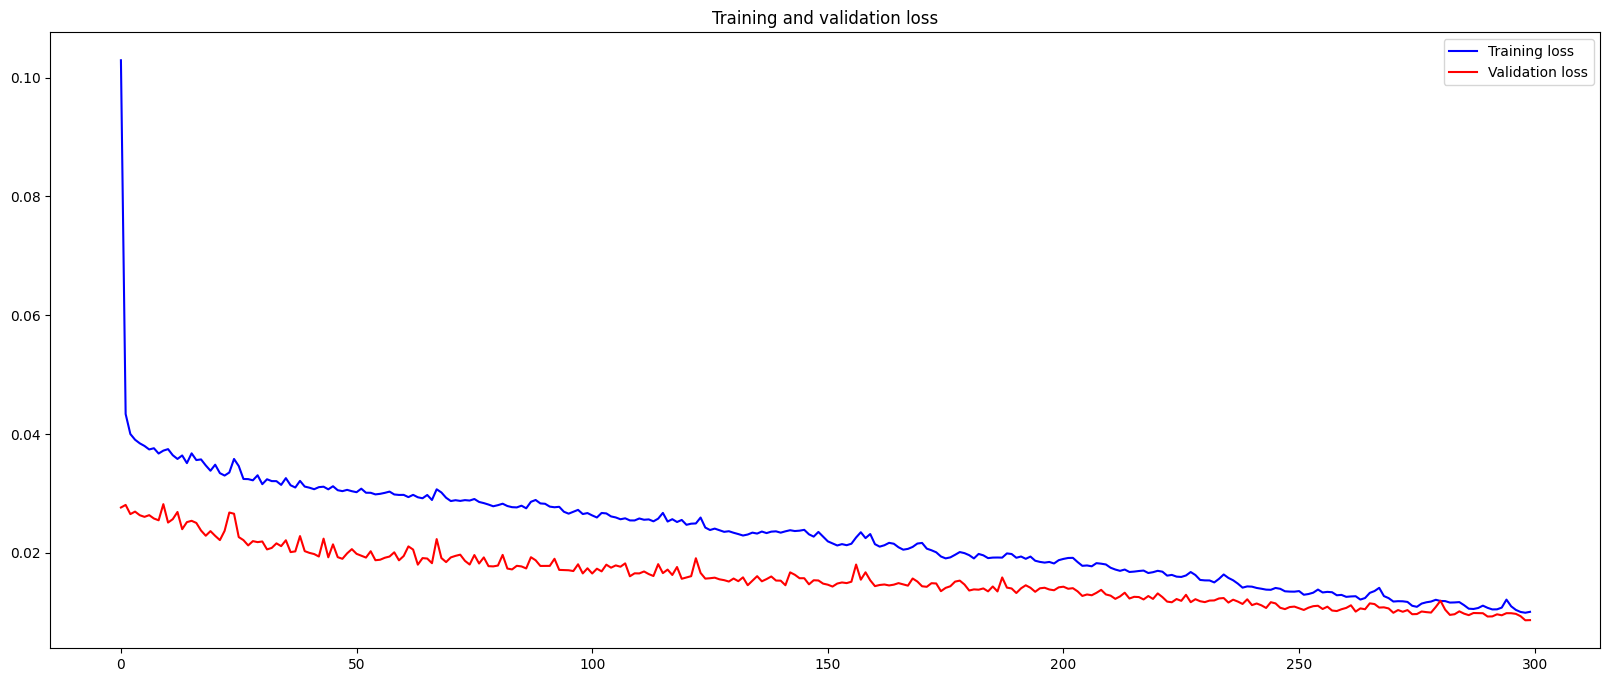

In [22]:
plot_loss(history_conv_lstm)

In [23]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step  


{'mae': np.float32(0.0069551794),
 'mse': np.float32(0.00012628897),
 'r2': 0.8871475458145142}

#### Plot predictions

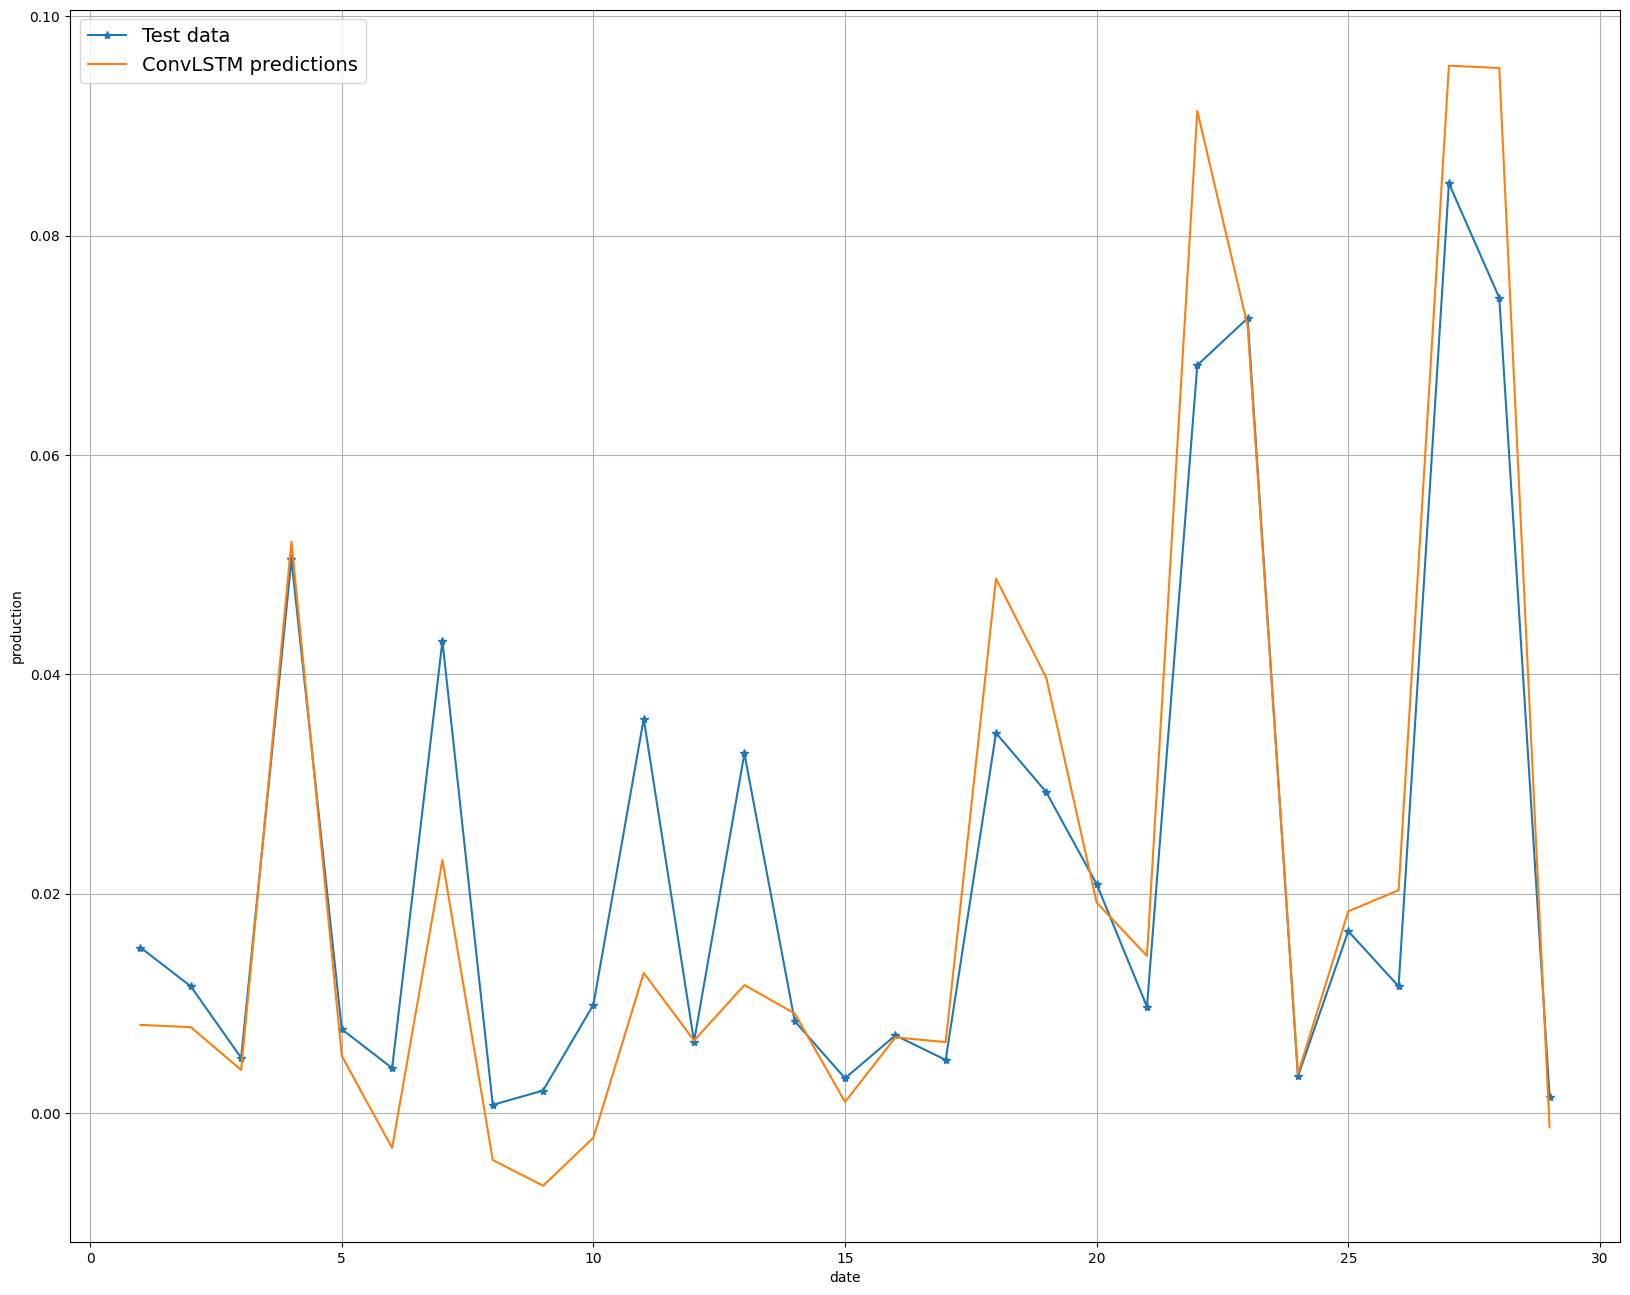

In [24]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)